In [1]:
from keras.applications import VGG16
conv_base = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
conv_base.summary()

Using TensorFlow backend.






58892288/58889256 [==============================] - 7s 0us/step






_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
b

In [2]:
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

base_dir = 'D:\data\deeplearningpython\Ch5_2'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(directory, target_size=(150, 150), batch_size=batch_size, class_mode='binary')
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            break
    return features, labels
train_features, train_labels = extract_features(train_dir, 2000)
validation_features, validation_labels = extract_features(validation_dir, 1000)
test_features, test_labels = extract_features(test_dir, 1000)

print(train_features.shape)
print(train_labels.shape)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
(2000, 4, 4, 512)
(2000,)


In [3]:
train_features = np.reshape(train_features, (2000, 4 * 4 * 512))
validation_features = np.reshape(validation_features, (1000, 4 * 4 * 512))
test_features = np.reshape(test_features, (1000, 4 * 4 * 512))

In [4]:
from keras import models
from keras import layers
from keras import optimizers

model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim=4 * 4 * 512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer=optimizers.RMSprop(lr=2e-5), loss='binary_crossentropy', metrics=['acc'])
history = model.fit(train_features, train_labels, epochs=30, batch_size=20, validation_data=(validation_features, validation_labels))


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 2000 samples, validate on 1000 samples
Epoch 1/30
2000/2000 [==============================] - 2s 1ms/step - loss: 0.5934 - acc: 0.6805 - val_loss: 0.4388 - val_acc: 0.8330
Epoch 2/30
2000/2000 [==============================] - 2s 1ms/step - loss: 0.4369 - acc: 0.7900 - val_loss: 0.3648 - val_acc: 0.8640
Epoch 3/30
2000/2000 [==============================] - 3s 1ms/step - loss: 0.3664 - acc: 0.8335 - val_loss: 0.3232 - val_acc: 0.8750
Epoch 4/30
2000/2000 [==============================] - 2s 958us/step - loss: 0.3157 - acc: 0.8675 - val_loss: 0.2995 - val_acc: 0.8840
Epoch 5/30
2000/2000 [==============================] - 2s 1ms/step - loss: 0.2919 - acc: 0.8790 - val_loss: 0.2855 - val_acc: 0.8910
Epoch 6/30
2000/2000 [==============================] - 2s 1ms/ste

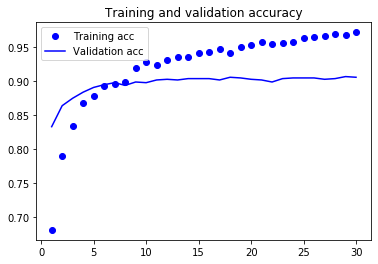

In [6]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.show()

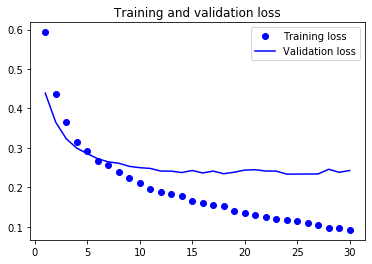

In [7]:
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [8]:
from keras import models
from keras import layers
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 16,812,353
Non-trainable params: 0
_________________________________________________________________


In [9]:
print('This is the number of trainable weights before freezing the conv base:', len(model.trainable_weights))
conv_base.trainable = False
print('This is the number of trainable weights after freezing the conv base:', len(model.trainable_weights))

This is the number of trainable weights before freezing the conv base: 30
This is the number of trainable weights after freezing the conv base: 4


In [10]:
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers

train_datagen = ImageDataGenerator(
    rescale=1./255, rotation_range=40, width_shift_range=0.2, height_shift_range=0.2,
    shear_range=0.2, zoom_range=0.2, horizontal_flip=True, fill_mode='nearest')
test_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(train_dir, target_size=(150, 150), batch_size=20, class_mode='binary')
validation_generator = test_datagen.flow_from_directory(validation_dir, target_size=(150, 150), batch_size=20, class_mode='binary')

model.compile(loss='binary_crossentropy', optimizer=optimizers.RMSprop(lr=2e-5), metrics=['acc'])
history = model.fit_generator(train_generator, steps_per_epoch=100, epochs=30, validation_data=validation_generator, validation_steps=50)


Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/30
100/100 [==============================] - 343s 3s/step - loss: 0.6022 - acc: 0.6810 - val_loss: 0.4481 - val_acc: 0.8230
Epoch 2/30
100/100 [==============================] - 342s 3s/step - loss: 0.4823 - acc: 0.7795 - val_loss: 0.3725 - val_acc: 0.8530
Epoch 3/30
100/100 [==============================] - 335s 3s/step - loss: 0.4452 - acc: 0.7930 - val_loss: 0.3348 - val_acc: 0.8720
Epoch 4/30
100/100 [==============================] - 336s 3s/step - loss: 0.4044 - acc: 0.8185 - val_loss: 0.3120 - val_acc: 0.8740
Epoch 5/30
100/100 [==============================] - 337s 3s/step - loss: 0.3775 - acc: 0.8335 - val_loss: 0.2902 - val_acc: 0.8830
Epoch 6/30
100/100 [==============================] - 331s 3s/step - loss: 0.3654 - acc: 0.8325 - val_loss: 0.2826 - val_acc: 0.8840
Epoch 7/30
100/100 [==============================] - 332s 3s/step - loss: 0.3578 - acc: 0.8435 - val_loss: 0.2743 - v

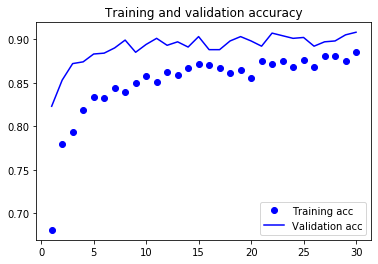

In [11]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.show()

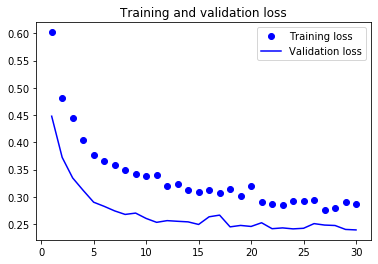

In [12]:
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [23]:
test_generator = test_datagen.flow_from_directory(test_dir, target_size=(150, 150), batch_size=20, class_mode='binary')
test_loss, test_acc = model.evaluate_generator(test_generator, steps=50)
print('test acc:', test_acc)

Found 1000 images belonging to 2 classes.
test acc: 0.887999997138977


In [24]:
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [25]:
model.compile(loss='binary_crossentropy', optimizer=optimizers.RMSprop(lr=1e-5), metrics=['acc'])
history = model.fit_generator(train_generator, steps_per_epoch=100, epochs=100, validation_data=validation_generator, validation_steps=50)

Epoch 1/100
100/100 [==============================] - 421s 4s/step - loss: 0.2847 - acc: 0.8795 - val_loss: 0.2489 - val_acc: 0.9010
Epoch 2/100
100/100 [==============================] - 413s 4s/step - loss: 0.2564 - acc: 0.8865 - val_loss: 0.2317 - val_acc: 0.9100
Epoch 3/100
100/100 [==============================] - 395s 4s/step - loss: 0.2461 - acc: 0.8990 - val_loss: 0.2418 - val_acc: 0.9100
Epoch 4/100
100/100 [==============================] - 392s 4s/step - loss: 0.2278 - acc: 0.9070 - val_loss: 0.2048 - val_acc: 0.9250
Epoch 5/100
100/100 [==============================] - 389s 4s/step - loss: 0.2082 - acc: 0.9090 - val_loss: 0.2068 - val_acc: 0.9200
Epoch 6/100
100/100 [==============================] - 403s 4s/step - loss: 0.1815 - acc: 0.9260 - val_loss: 0.2396 - val_acc: 0.9160
Epoch 7/100
100/100 [==============================] - 466s 5s/step - loss: 0.1863 - acc: 0.9255 - val_loss: 0.1704 - val_acc: 0.9330
Epoch 8/100
100/100 [==============================] - 472s 5s

Epoch 62/100
100/100 [==============================] - 406s 4s/step - loss: 0.0239 - acc: 0.9940 - val_loss: 0.2267 - val_acc: 0.9450
Epoch 63/100
100/100 [==============================] - 377s 4s/step - loss: 0.0291 - acc: 0.9910 - val_loss: 0.2513 - val_acc: 0.9380
Epoch 64/100
100/100 [==============================] - 376s 4s/step - loss: 0.0338 - acc: 0.9865 - val_loss: 0.2469 - val_acc: 0.9350
Epoch 65/100
100/100 [==============================] - 376s 4s/step - loss: 0.0321 - acc: 0.9895 - val_loss: 0.3579 - val_acc: 0.9200
Epoch 66/100
100/100 [==============================] - 377s 4s/step - loss: 0.0256 - acc: 0.9900 - val_loss: 0.1836 - val_acc: 0.9340
Epoch 67/100
100/100 [==============================] - 386s 4s/step - loss: 0.0270 - acc: 0.9930 - val_loss: 0.2539 - val_acc: 0.9330
Epoch 68/100
100/100 [==============================] - 404s 4s/step - loss: 0.0330 - acc: 0.9860 - val_loss: 0.4511 - val_acc: 0.9170
Epoch 69/100
100/100 [==============================] -

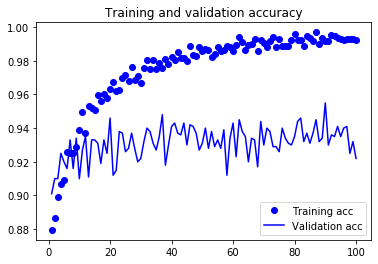

In [26]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.show()

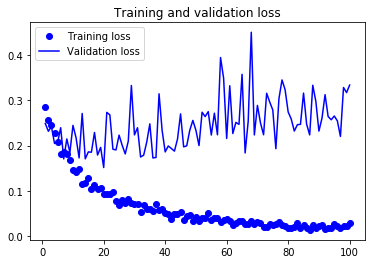

In [27]:
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

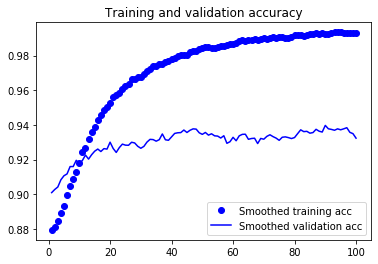

In [28]:
def smooth_curve(points, factor=0.8):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points
plt.plot(epochs, smooth_curve(acc), 'bo', label='Smoothed training acc')
plt.plot(epochs, smooth_curve(val_acc), 'b', label='Smoothed validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.show()

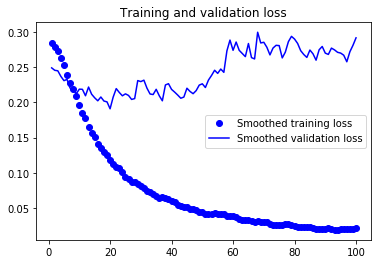

In [29]:
plt.plot(epochs, smooth_curve(loss), 'bo', label='Smoothed training loss')
plt.plot(epochs, smooth_curve(val_loss), 'b', label='Smoothed validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [30]:
test_generator = test_datagen.flow_from_directory(test_dir, target_size=(150, 150), batch_size=20, class_mode='binary')
test_loss, test_acc = model.evaluate_generator(test_generator, steps=50)
print('test acc:', test_acc)

Found 1000 images belonging to 2 classes.
test acc: 0.9349999940395355
